<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/33_4_Watermarked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание 2. На 4 балла:**
1. Используйте  изображения без водяных знаков из 3-й части урока (https://storage.yandexcloud.net/academy.ai/watermarked.zip)

2. Придумайте механизм нанесения водяных знаков (может быть обычный текст) на изображения. Нанесите водяные знаки на входные изображения.

3. Подумайте над архитектурой автокодировщика.

4. Размер картинок, число образцов для обучения выбирайте, исходя из ограничения среды выполнения, например,
ограничения ОЗУ бесплатного колаба.

5. Обучите модель и сделайте предсказания на контрольной выборке.

6. Продемонстрируйте работу модели путём вывода не менее 10 примеров из тестовой выборки, содержащих: исходное изображение, изображение с водяными знаками, предсказанное изображение и изображение шума (полученное путём вычитания предсказанного изображения из изображения).

In [1]:
%%capture
!pip install keras

In [1]:
import numpy as np
from keras.models import Model
from keras import utils
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, Conv2DTranspose, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2
import os
from keras.preprocessing.image import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://storage.yandexcloud.net/academy.ai/watermarked.zip
!unzip -qo "watermarked.zip" -d ./watermarked

--2024-12-29 13:43:18--  https://storage.yandexcloud.net/academy.ai/watermarked.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 731796045 (698M) [application/x-zip-compressed]
Saving to: ‘watermarked.zip’

watermarked.zip     100%[===================>] 697.89M  15.0MB/s    in 49s     

2024-12-29 13:44:08 (14.2 MB/s) - ‘watermarked.zip’ saved [731796045/731796045]



In [3]:
os.listdir('./watermarked/wm-nowm') # папки с изображениями

['train', 'valid']

In [4]:
train_path = './watermarked/wm-nowm/train' # тренировочные образцы
valid_path = './watermarked/wm-nowm/valid' # контрольные образцы

In [5]:
os.listdir(train_path)

['watermark', 'no-watermark']

In [6]:
os.listdir(valid_path)

['watermark', 'no-watermark']

In [7]:
train_path_no = os.path.join(train_path, 'no-watermark')
train_path_wm = os.path.join(train_path, 'watermark')
valid_path_no = os.path.join(valid_path, 'no-watermark')
valid_path_wm = os.path.join(valid_path, 'watermark')

In [8]:
train_nonwatermarked = [] # список файлов без водяных знаков (тренировочная выборка)
train_watermarked = []  # список файлов с водяными знаков (тренировочная выборка)
valid_nonwatermarked = [] # список файлов без водяных знаков (контрольная выборка)
valid_watermarked = [] # список файлов с водяными знаков (контрольная выборка)

# Обнаружено в датасете не соответствие, просто удалим файл
try:
    os.remove('./watermarked/wm-nowm/train/watermark/animal-dog-pet-cute.jpg')
except Exception as e:
    print(e) # вывод ошибки загрузки или масштабирования картинки

# Найдем парные файлы для тренировочной выборки
for file_no in sorted(os.listdir(train_path_no)):
    for file_wm in sorted(os.listdir(train_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            train_nonwatermarked.append(os.path.join(train_path_no, file_no))
            train_watermarked.append(os.path.join(train_path_wm, file_wm))

# Найдем парные файлы для контрольной выборки
for file_no in sorted(os.listdir(valid_path_no)):
    for file_wm in sorted(os.listdir(valid_path_wm)):
        # Если имена файлов в обеих папках совпадают, то добавляем пути к этим файлам в списки
        if file_no == file_wm:
            valid_nonwatermarked.append(os.path.join(valid_path_no, file_no))
            valid_watermarked.append(os.path.join(valid_path_wm, file_wm))

In [9]:
print('Обучающая выборка содержит:')
print(len(train_nonwatermarked), 'файлов без водяных знаков')
print(len(train_watermarked), 'файлов с водяными знаками')

Обучающая выборка содержит:
12477 файлов без водяных знаков
12477 файлов с водяными знаками


In [10]:
print('Контрольная выборка содержит:')
print(len(valid_nonwatermarked), 'файлов без водяных знаков')
print(len(valid_watermarked), 'файлов с водяными знаками')

Контрольная выборка содержит:
3289 файлов без водяных знаков
3289 файлов с водяными знаками


In [11]:
# Размер преобразованных картинок
width = 148
height = 148
dim = (width, height)

# Функция загрузки и масштабирования картинок
def createPixelArr(files):
    data = []
    for image in files: # цикл по каждой картинке в списке
        try:
            # Загрузим изображение в матрицу (сохранив цвета, загружает как BGR)
            img_arr = cv2.imread(image, cv2.IMREAD_COLOR)
            resized_arr = cv2.resize(img_arr, (width, height)) # масштабируем изображение
            data.append(resized_arr) # добавляем в список матрицу пикселей картинки
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data) # возвращаем набор картинок как матрицу

In [15]:
# Функция добавления водяных знаков
def add_watermarked(files):
    data_1 = []
    position = (10, 10)
    for image in files: # цикл по каждой картинке в списке
        try:
            img_arr = cv2.imread(image, cv2.IMREAD_UNCHANGED)
            new_arr = cv2.putText(image, "Hello Founder!", position, cv2.FONT_HERSHEY_SIMPLEX, 1, (200, 80, 0, 255), 2)
            data_1.append(new_arr)
        except Exception as e:
            print(e) # вывод ошибки загрузки или масштабирования картинки
    return np.array(data_1) # возвращаем набор картинок как матрицу

In [16]:
y_train = createPixelArr(train_nonwatermarked) # подготовка картинок (без знаков, обучающая выборка)
X_train = createPixelArr(train_watermarked)    # подготовка картинок (водяные знаки, обучающая выборка)
X_train = add_watermarked(train_watermarked)    # подготовка картинок (водяные знаки, обучающая выборка)

y_test = createPixelArr(valid_nonwatermarked)  # подготовка картинок (без знаков, контрольная выборка)
X_test = createPixelArr(valid_watermarked)     # подготовка картинок (водяные знаки, контрольная выборка)
X_test = add_watermarked(valid_watermarked)     # подготовка картинок (водяные знаки, контрольная выборка)

Выходные данные были обрезаны до нескольких последних строк (5000).
OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'

OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected P

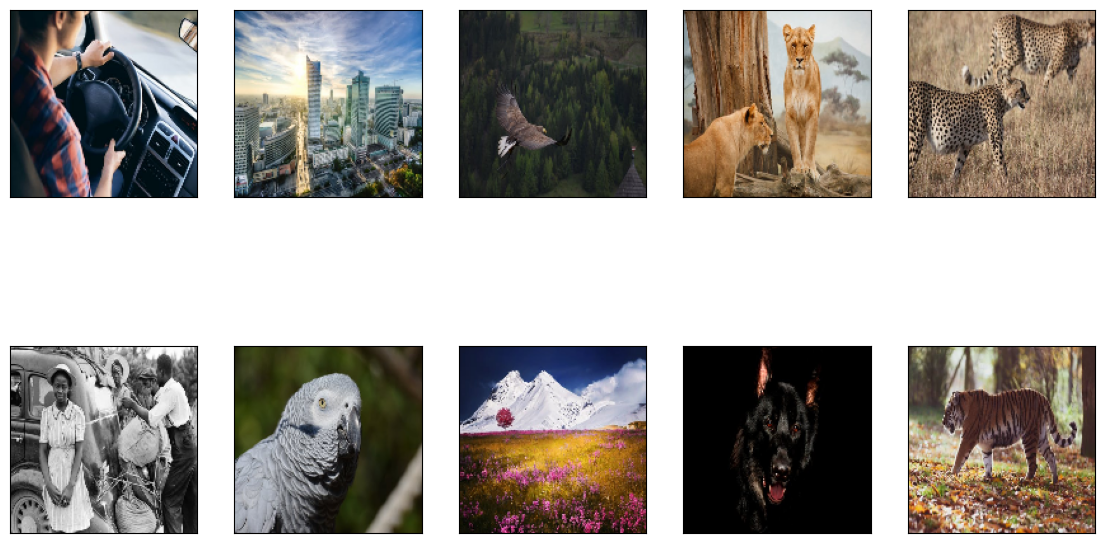

In [17]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Преобразуем картинку в формат RGB перед выводом
    plt.imshow(cv2.cvtColor(y_train[i], cv2.COLOR_BGR2RGB))
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

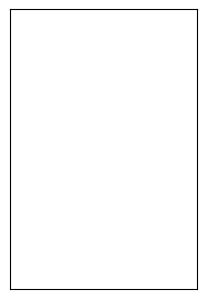

In [18]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Преобразуем картинку в формат RGB перед выводом
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
plt.show()

In [29]:
train_nonwatermarked = None
train_watermarked    = None
valid_nonwatermarked = None
valid_watermarked    = None

In [30]:
# Функции аугментации изображений

def data_augmentation(inputImage): # функция прогоняет картинки через все методы аугментации
    return randomContrast(randomBrightness(inputImage)).numpy()


def randomBrightness(pic): # добавляем изображению случайную яркость от 1% до 20%
    return tf.image.random_brightness(pic, random.uniform(0.01, 0.2), 1)

def randomContrast(pic): # добавляем изображению случайную контрастность от 5% до 50%
    return tf.image.random_contrast(pic, 0.2, 0.7, 1)

In [33]:
data_augmented_X = []
data_augmented_y = []

for image in X_train:
    data_augmented_X.append(data_augmentation(image))

for image in y_train:
    data_augmented_y.append(data_augmentation(image))

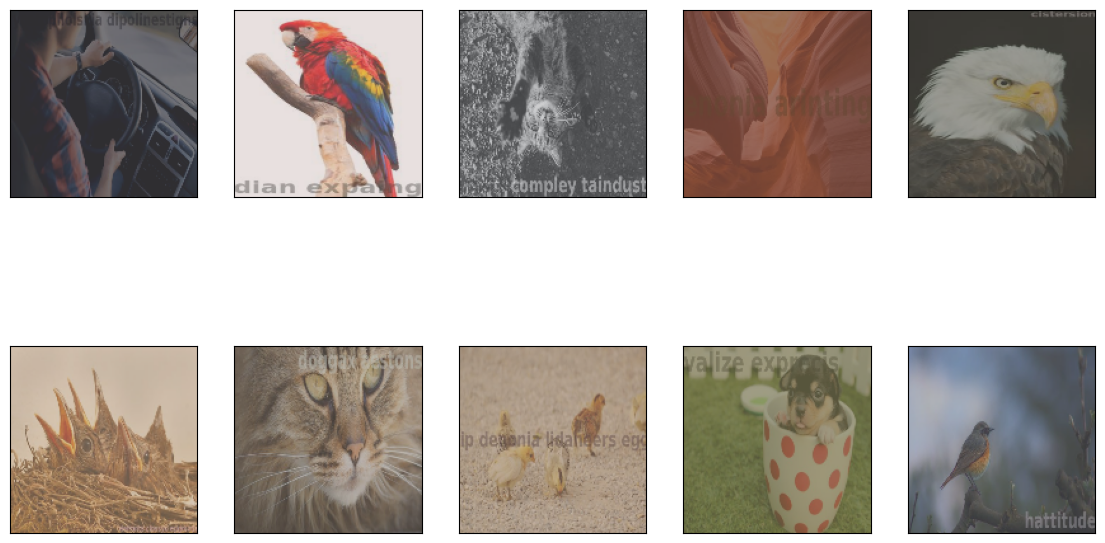

In [34]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_X[i], cv2.COLOR_BGR2RGB))
plt.show()

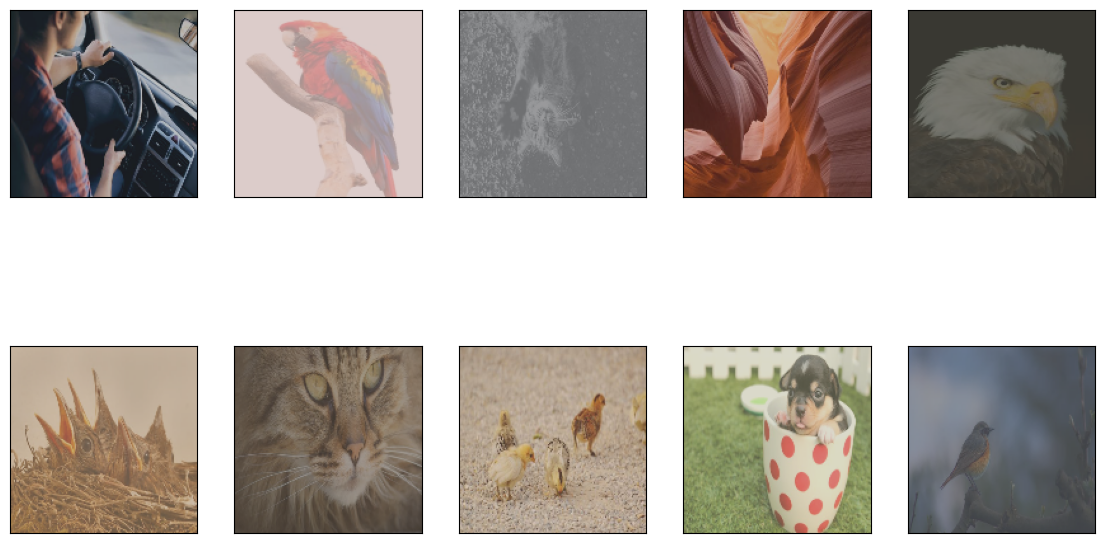

In [35]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(data_augmented_y[i], cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
X_train = np.append(X_train, data_augmented_X, axis=0)
y_train = np.append(y_train, data_augmented_y, axis=0)

In [37]:
X_train = X_train.astype('float32') / 255.
y_train = y_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

In [38]:
def create_model(img_x, img_y, channel):
    inputs = Input(shape=(img_x, img_y, channel))

    # Кодировщик - сжимает входные данные в латентное пространство
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    h = MaxPooling2D((2, 2), padding='same')(x)

    # Декодировщик - реконструирует сжатое представление
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(h)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)

    outputs = Conv2D(channel, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='mse',  metrics=['acc'])
    return model

In [39]:
watermark_auto_encoder = create_model(width, height, 3)

Схема сверточного автокодировщика:


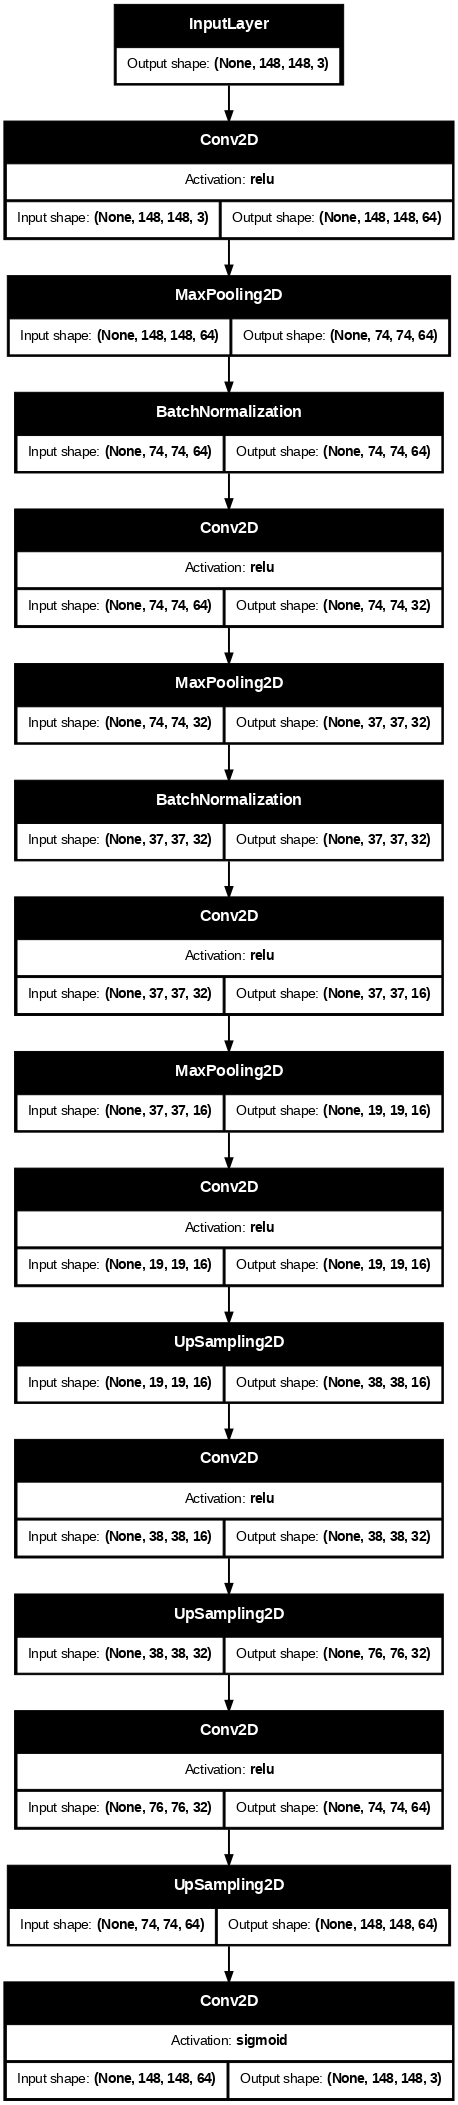

In [40]:
print('Схема сверточного автокодировщика:')
utils.plot_model(watermark_auto_encoder, show_shapes=True, dpi=70, show_layer_activations=True, expand_nested=True)

In [41]:
early_stop = EarlyStopping(monitor='loss', patience=6, restore_best_weights=True)
history = watermark_auto_encoder.fit(X_train, y_train, batch_size=128, epochs=100, callbacks=[early_stop])

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 666s 24s/step - acc: 0.2414 - loss: 0.0571
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 738s 26s/step - acc: 0.4183 - loss: 0.0245
Epoch 3/100


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt           # библиотека для рисования графиков
acc = history.history['acc']              # данные о точности на обучающей выборке
loss = history.history['loss']            # данные об ошибке на обучающей выборке
epochs = range(1, len(acc) + 1)           # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()                                                                 #  рисуем график

In [ ]:
result = watermark_auto_encoder.predict(X_test)

In [ ]:
plt.imshow(cv2.cvtColor(result[21], cv2.COLOR_BGR2RGB))

In [ ]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(X_test[i].astype('float32'), cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
for i in range(10):
    plt.subplot(2, 5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))
plt.show()